In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer

In [2]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

x_train_imputed['DE_GAS_COAL_INTERACTION'] = x_train_imputed['DE_GAS'] * x_train_imputed['DE_COAL']
x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()
x_train_imputed['FR_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_CONSUMPTION'].cumsum()
x_train_imputed['DE_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_CONSUMPTION'].cumsum()
x_test_imputed['GAS_COAL_INTERACTION'] = x_test_imputed['DE_GAS'] * x_test_imputed['DE_COAL']


x_train_imputed


,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
0,1054.0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,-0.789557,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.0,1.0,0.326793,0.789557,0.692860,-0.427458,0.210099
1,2049.0,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0.0,1.0,-0.029780,-0.573520,-1.130838,-1.003452,-0.022399
2,1924.0,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0.0,1.0,3.697835,-0.622021,-1.682587,1.978665,1.395035
3,297.0,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1.0,0.0,-0.718955,-0.270870,0.563230,-0.849198,-0.983324
4,1101.0,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,-0.471847,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0.0,1.0,0.239584,0.471847,0.990324,-0.617038,0.143807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,-0.238427,0.876984,0.819520,1.320373,1.0,0.0,0.651338,-0.437317,2.900852,2.213364,3.058408
1490,1674.0,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,-1.071237,0.932633,-0.085690,0.356356,0.0,1.0,1.107431,0.898307,-0.304292,3.505680,3.237163
1491,748.0,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,1.0,0.0,2.261762,-3.063088,-1.659137,0.978397,1.712799
1492,1454.0,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.619473,0.918251,0.378080,-0.973969,-0.828580,-0.137667,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,0.0,1.0,0.001736,-0.609711,2.4

In [3]:
x_train_imputed.sort_values(by = 'DAY_ID', inplace = True)

In [4]:
x_train_imputed.head()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
742,1057.0,0.0,0.048418,-0.465067,-0.079296,0.079296,1.097725,0.650577,-1.097725,-0.650577,0.592572,-0.261565,0.534535,0.095197,1.312903,0.677089,0.470981,-0.357168,1.336885,1.185155,-0.726830,-0.874690,1.018472,0.261776,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.0,1.0,0.316750,1.097725,0.650577,-0.465067,0.048418
1211,1179.0,1.0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,1.991028,0.660390,-0.786509,-0.681081,0.709616,0.830659,1.381575,0.136060,0.485975,-0.360309,-0.172140,1.090374,0.935387,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,0.0,1.0,0.733698,0.405549,0.778627,1.222131,0.966997
1408,1327.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,0.0,1.0,-0.304200,-1.080403,0.256736,-0.667390,-0.068972
1468,111.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,0.0,-0.304200,-2.160807,0.513472,-1.334780,-0.137944
329,2016.0,3.0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,-0.383690,-2.002323,-1.579208,1.527633,2.986527,-1.142488,-0.718643,-0.169336,0.275487,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.0,1.0,-1.009441,-1.881881,-0.612133,-0.834564,-0.134670


In [5]:
X_plot = x_train_imputed[:100]

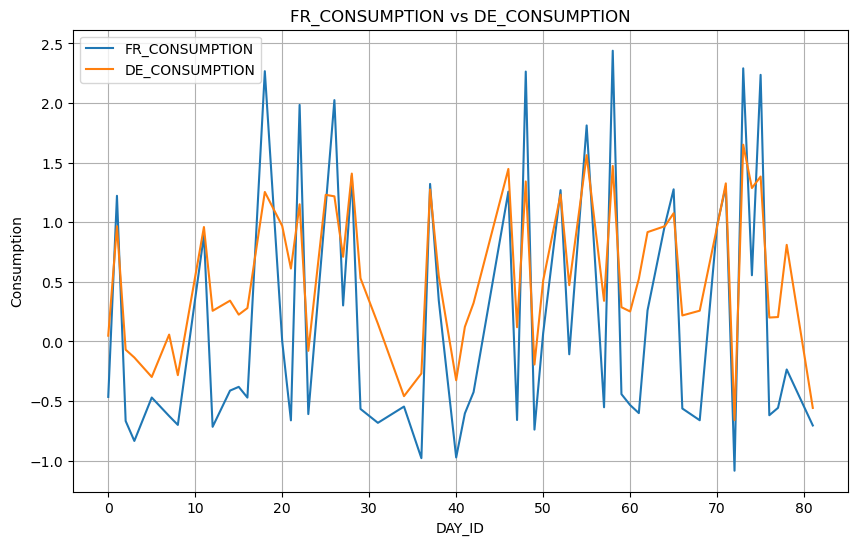

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['FR_CONSUMPTION'], label='FR_CONSUMPTION')
plt.plot(X_plot['DAY_ID'], X_plot['DE_CONSUMPTION'], label='DE_CONSUMPTION')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('FR_CONSUMPTION vs DE_CONSUMPTION')
plt.legend()
plt.grid(True)
plt.show()


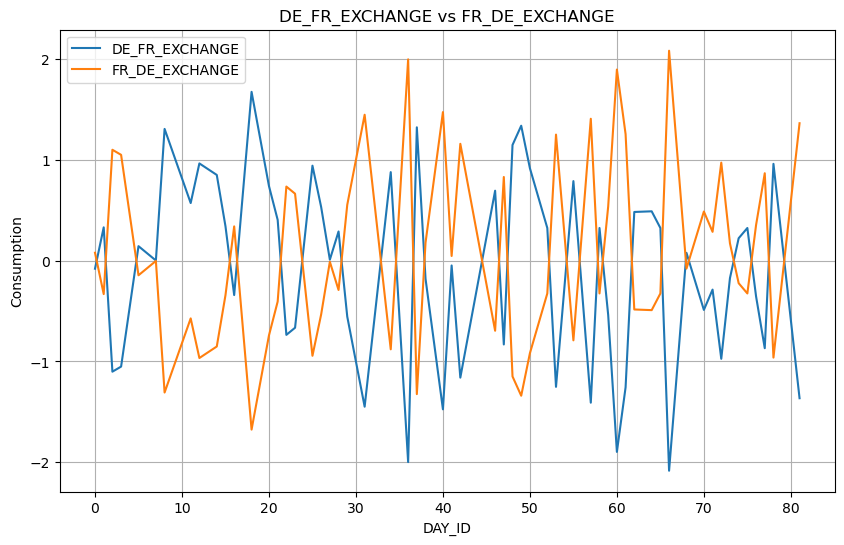

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['DE_FR_EXCHANGE'], label='DE_FR_EXCHANGE')
plt.plot(X_plot['DAY_ID'], X_plot['FR_DE_EXCHANGE'], label='FR_DE_EXCHANGE')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('DE_FR_EXCHANGE vs FR_DE_EXCHANGE')
plt.legend()
plt.grid(True)
plt.show()

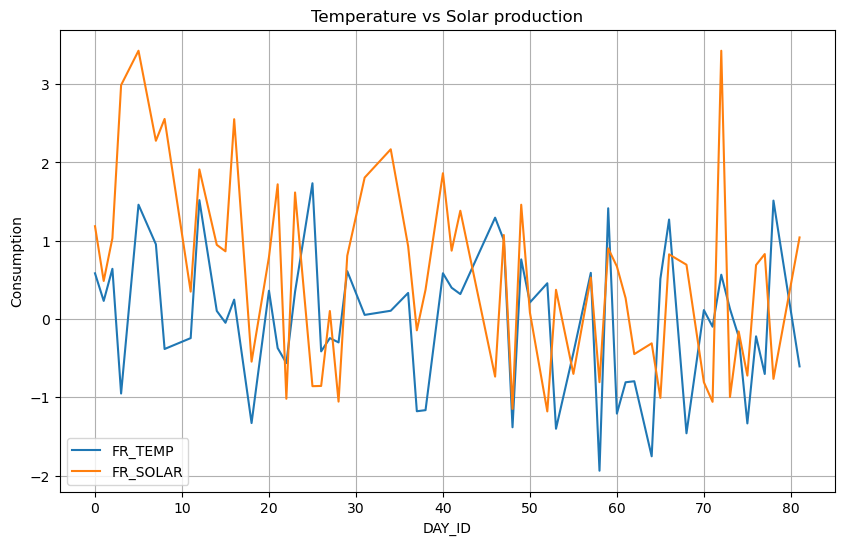

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['FR_TEMP'], label='FR_TEMP')
plt.plot(X_plot['DAY_ID'], X_plot['FR_SOLAR'], label='FR_SOLAR')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('Temperature vs Solar production')
plt.legend()
plt.grid(True)
plt.show()

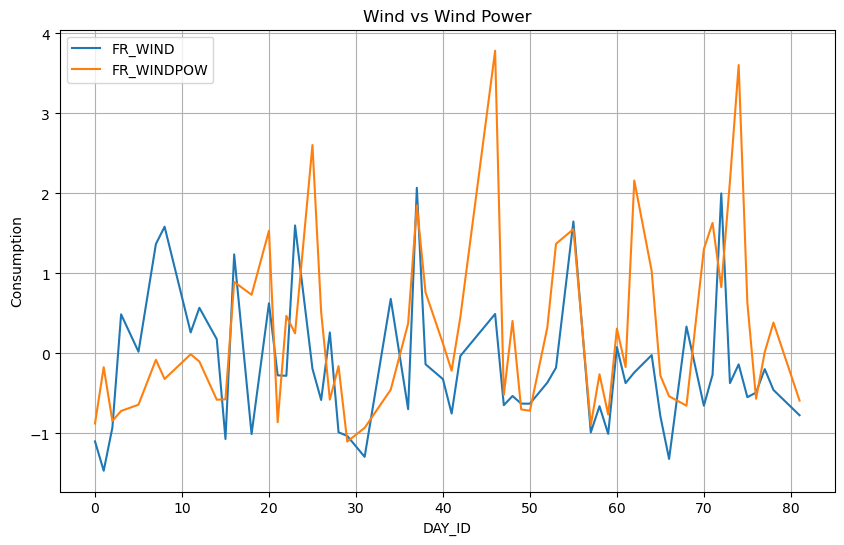

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['FR_WIND'], label='FR_WIND')
plt.plot(X_plot['DAY_ID'], X_plot['FR_WINDPOW'], label='FR_WINDPOW')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('Wind vs Wind Power')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
correlation_fr_windpow_wind = X_plot['FR_WINDPOW'].corr(X_plot['FR_WIND'])

X_plot['FR_WIND_lag1'] = X_plot['FR_WIND'].shift(1)

# Calculate correlation between lagged FR_WIND and FR_WINDPOW
correlation_fr_wind_lag1_windpow = X_plot['FR_WIND_lag1'].corr(X_plot['FR_WINDPOW'])

# Print the results
print(f"Correlation between FR_WINDPOW and FR_WIND: {correlation_fr_windpow_wind}")
print(f"Correlation between lagged FR_WIND and FR_WINDPOW: {correlation_fr_wind_lag1_windpow}")


Correlation between FR_WINDPOW and FR_WIND: 0.28081787444621154
Correlation between lagged FR_WIND and FR_WINDPOW: 0.19941836748498168


/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_85789/1063211505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_plot['FR_WIND_lag1'] = X_plot['FR_WIND'].shift(1)


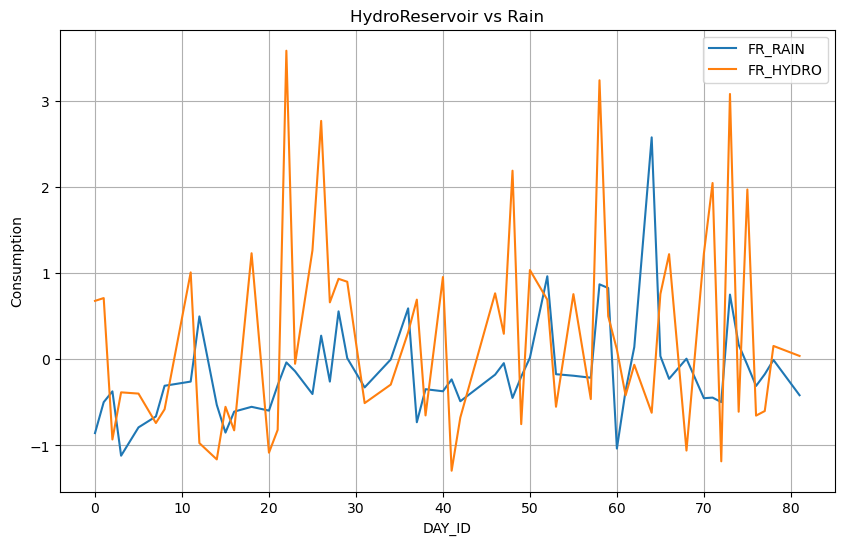

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['FR_RAIN'], label='FR_RAIN')
plt.plot(X_plot['DAY_ID'], X_plot['FR_HYDRO'], label='FR_HYDRO')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('HydroReservoir vs Rain')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['FR_RAIN'], label='FR_RAIN')
plt.plot(X_plot['DAY_ID'], X_plot['FR_HYDRO'], label='FR_HYDRO')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('HydroReservoir vs Rain')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
X_plot.head()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum,FR_WIND_lag1
742,1057.0,0.0,0.048418,-0.465067,-0.079296,0.079296,1.097725,0.650577,-1.097725,-0.650577,0.592572,-0.261565,0.534535,0.095197,1.312903,0.677089,0.470981,-0.357168,1.336885,1.185155,-0.726830,-0.874690,1.018472,0.261776,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.0,1.0,0.316750,1.097725,0.650577,-0.465067,0.048418,NaN
1211,1179.0,1.0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,1.991028,0.660390,-0.786509,-0.681081,0.709616,0.830659,1.381575,0.136060,0.485975,-0.360309,-0.172140,1.090374,0.935387,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,0.0,1.0,0.733698,0.405549,0.778627,1.222131,0.966997,-1.099226
1408,1327.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,0.0,1.0,-0.304200,-1.080403,0.256736,-0.667390,-0.068972,-1.465608
1468,111.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,0.0,-0.304200,-2.160807,0.513472,-1.334780,-0.137944,-0.926064
329,2016.0,3.0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,-0.383690,-2.002323,-1.579208,1.527633,2.986527,-1.142488,-0.718643,-0.169336,0.275487,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.0,1.0,-1.009441,-1.881881,-0.612133,-0.834564,-0.134670,-0.926064


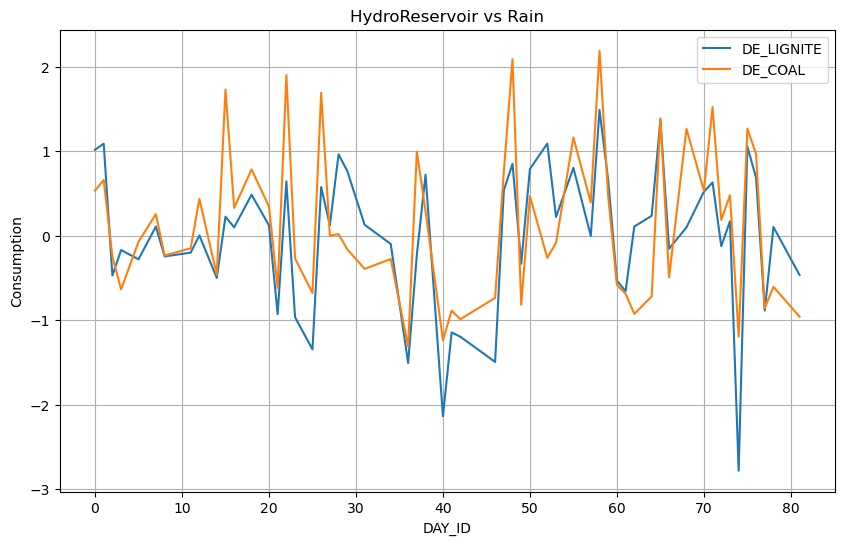

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(X_plot['DAY_ID'], X_plot['DE_LIGNITE'], label='DE_LIGNITE')
plt.plot(X_plot['DAY_ID'], X_plot['DE_COAL'], label='DE_COAL')
plt.xlabel('DAY_ID')
plt.ylabel('Consumption')
plt.title('HydroReservoir vs Rain')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
x_train_imputed['FR_EXPWIND'] = x_train_imputed['FR_WINDPOW'] ** x_train_imputed['FR_WIND']


In [26]:
data_merged = pd.merge(x_train_imputed, y_train, on='ID')

# Exclude non-numeric columns from data_merged for correlation analysis
numeric_columns = data_merged.select_dtypes(include=[np.number]).columns.tolist()

# Calculate the correlation matrix for numeric columns only
correlation_matrix = data_merged[numeric_columns].corr()

# Extracting correlation of features with the target variable for detailed insights
target_correlation = correlation_matrix['TARGET'].sort_values(key=abs, ascending=False)
target_correlation

TARGET                     1.000000
DE_WINDPOW                -0.150287
DE_NET_EXPORT             -0.149348
DE_NET_IMPORT              0.149348
DE_NET_EXPORT_cumsum      -0.142318
DE_RESIDUAL_LOAD           0.132555
FR_WINDPOW                -0.132523
DE_GAS                     0.096657
DE_HYDRO                   0.086127
DE_WIND                   -0.077154
FR_HYDRO                   0.052820
DE_CONSUMPTION            -0.052565
COUNTRY_FR                -0.048840
COUNTRY_DE                 0.048840
ID                        -0.048030
FR_WIND                   -0.047421
DE_COAL                    0.045181
FR_TEMP                   -0.044339
FR_EXPWIND                -0.044052
GAS_RET                    0.041969
FR_RAIN                   -0.041570
DE_TEMP                   -0.040451
DE_RAIN                   -0.038890
CARBON_RET                 0.038252
DE_CONSUMPTION_cumsum     -0.036142
DE_LIGNITE                 0.034433
FR_RESIDUAL_LOAD           0.030254
FR_NET_IMPORT              0